In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.004, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9600e-01, 9.9196e-01, 9.8789e-01, 9.8379e-01, 9.7965e-01, 9.7547e-01,
        9.7127e-01, 9.6703e-01, 9.6276e-01, 9.5845e-01, 9.5412e-01, 9.4976e-01,
        9.4536e-01, 9.4094e-01, 9.3649e-01, 9.3201e-01, 9.2751e-01, 9.2298e-01,
        9.1842e-01, 9.1384e-01, 9.0923e-01, 9.0460e-01, 8.9994e-01, 8.9526e-01,
        8.9056e-01, 8.8584e-01, 8.8110e-01, 8.7633e-01, 8.7155e-01, 8.6675e-01,
        8.6192e-01, 8.5708e-01, 8.5223e-01, 8.4735e-01, 8.4246e-01, 8.3756e-01,
        8.3264e-01, 8.2770e-01, 8.2275e-01, 8.1779e-01, 8.1281e-01, 8.0782e-01,
        8.0282e-01, 7.9781e-01, 7.9279e-01, 7.8776e-01, 7.8273e-01, 7.7768e-01,
        7.7262e-01, 7.6756e-01, 7.6249e-01, 7.5741e-01, 7.5233e-01, 7.4724e-01,
        7.4215e-01, 7.3706e-01, 7.3196e-01, 7.2686e-01, 7.2175e-01, 7.1665e-01,
        7.1154e-01, 7.0643e-01, 7.0132e-01, 6.9622e-01, 6.9111e-01, 6.8601e-01,
        6.8090e-01, 6.7580e-01, 6.7070e-01, 6.6561e-01, 6.6052e-01, 6.5543e-01,
        6.5035e-01, 6.4528e-01, 6.4021e-

torch.Size([4, 3, 72, 72])


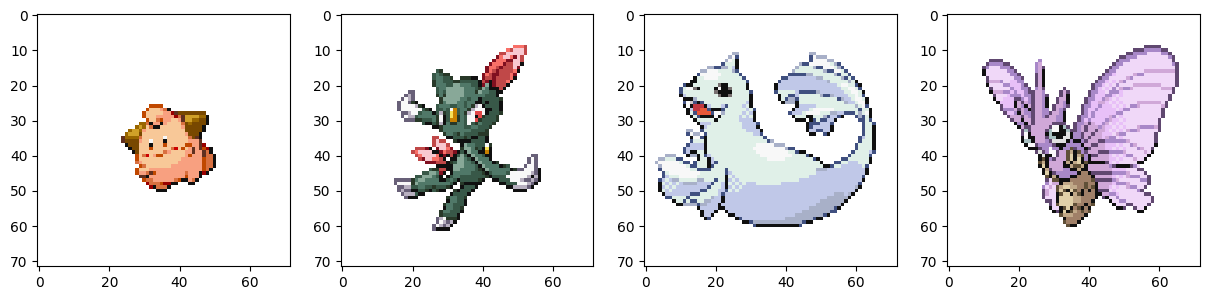

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .1),
    v2.RandomApply([v2.RandomChannelPermutation()], .1),
    #v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Grass"], ["Fire"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

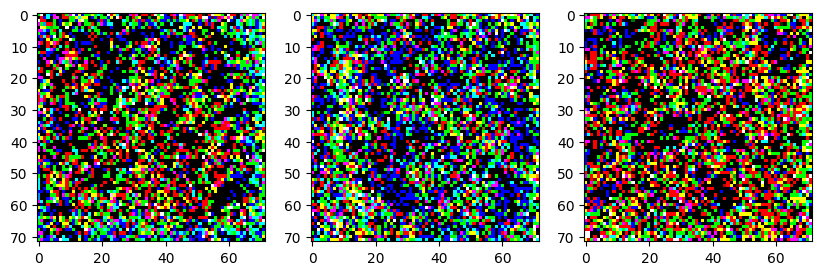

0.02995895:   1%|          | 1000/100001 [00:52<1:21:51, 20.16it/s]

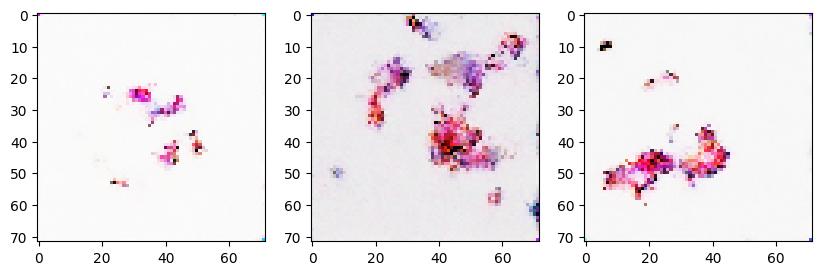

0.03210254:   2%|▏         | 1998/100001 [01:44<1:21:29, 20.04it/s]

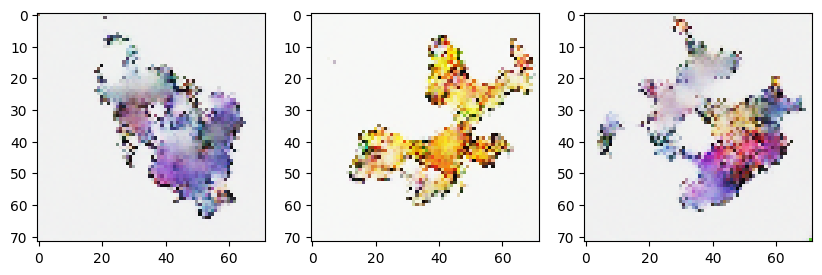

0.02680917:   3%|▎         | 3000/100001 [02:37<1:20:40, 20.04it/s]

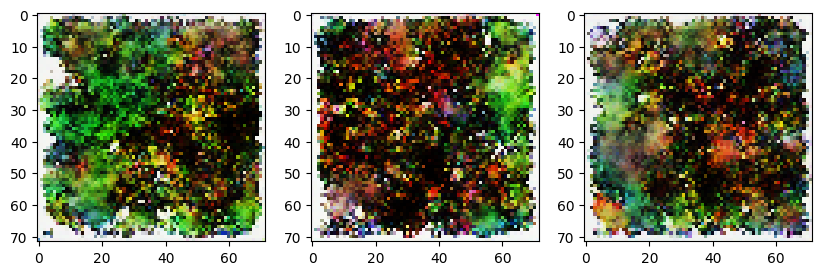

0.05084118:   4%|▍         | 3998/100001 [03:30<1:19:51, 20.03it/s]

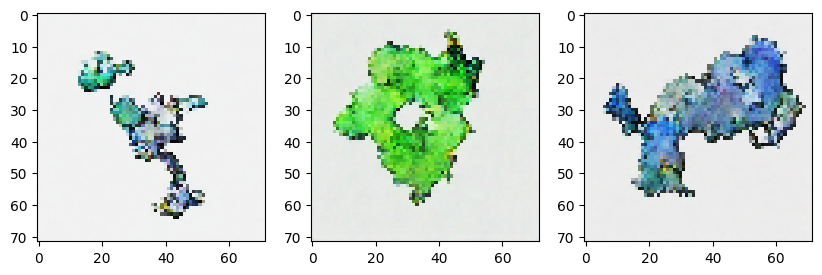

0.04749879:   5%|▍         | 5000/100001 [04:22<1:19:00, 20.04it/s]

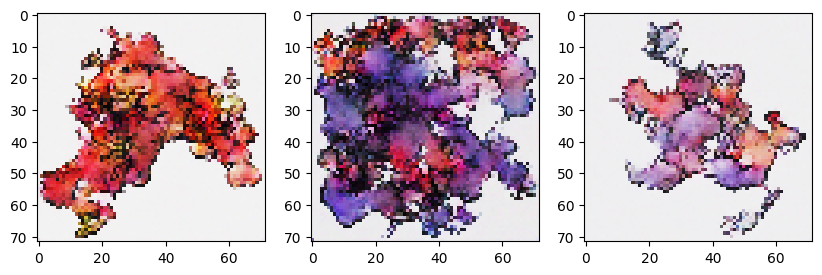

0.04819191:   6%|▌         | 5999/100001 [05:15<1:18:10, 20.04it/s]

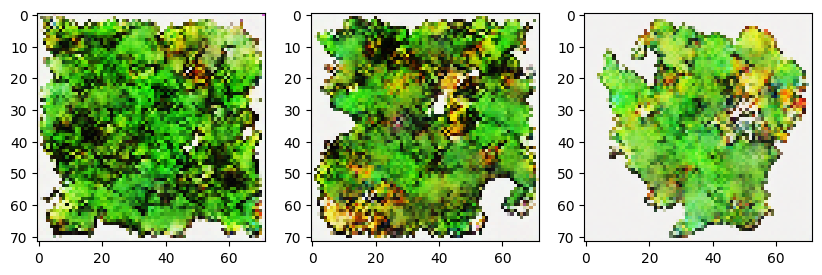

0.04973935:   7%|▋         | 6999/100001 [06:08<1:17:21, 20.04it/s]

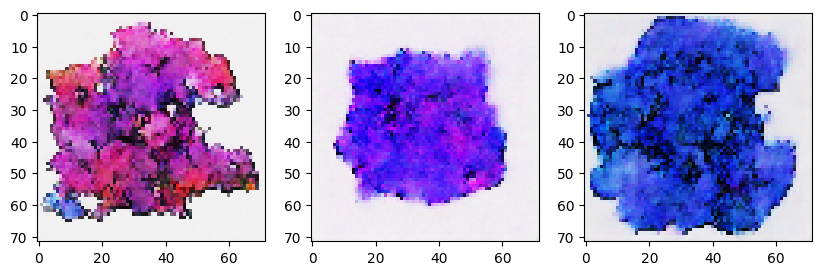

0.04667408:   8%|▊         | 8000/100001 [07:00<1:16:35, 20.02it/s]

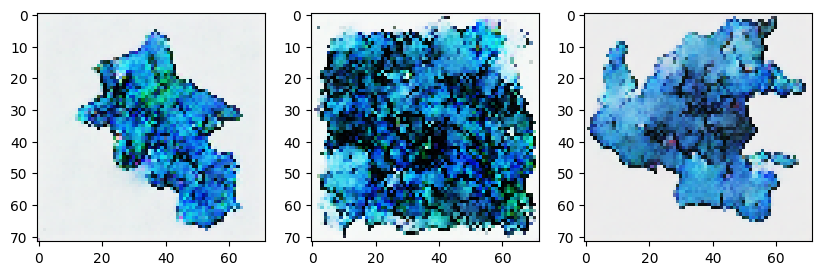

0.03082076:   9%|▉         | 9000/100001 [07:53<1:15:52, 19.99it/s]

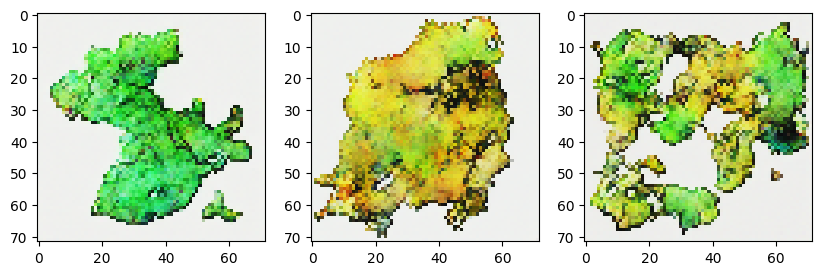

0.04093305:  10%|▉         | 9999/100001 [08:45<1:14:53, 20.03it/s] 

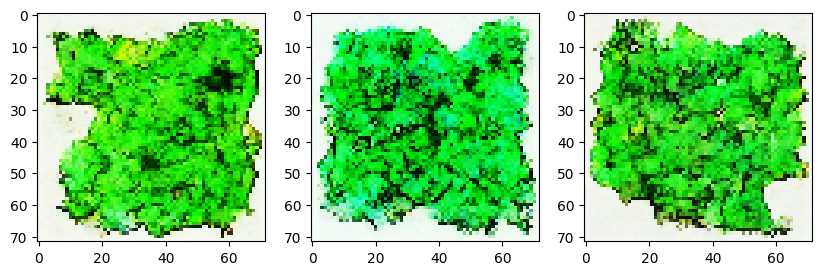

0.03404138:  11%|█         | 10998/100001 [09:38<1:14:07, 20.01it/s]

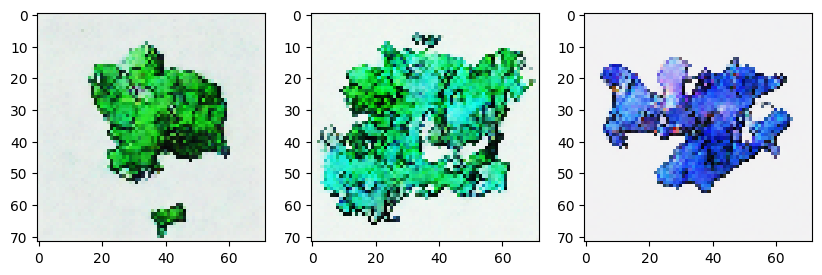

0.03836212:  12%|█▏        | 11999/100001 [10:31<1:13:10, 20.04it/s]

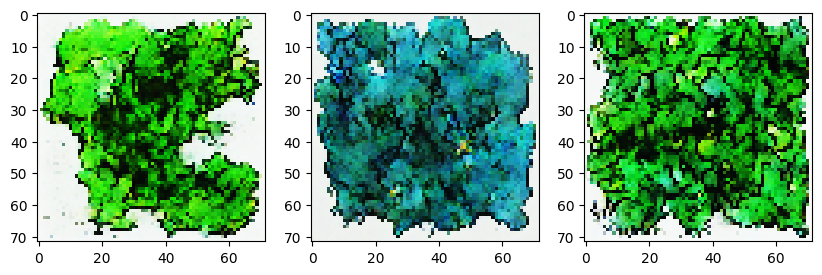

0.02550053:  13%|█▎        | 13000/100001 [11:23<1:12:34, 19.98it/s]

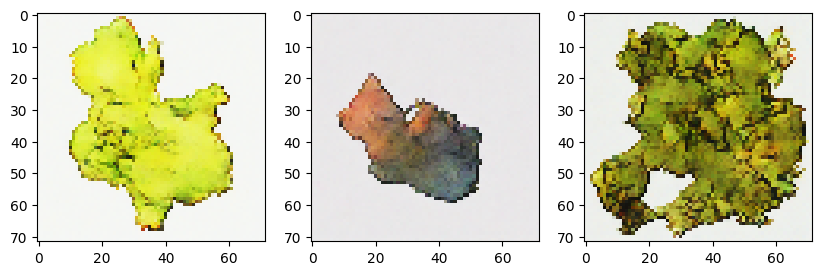

0.01954595:  14%|█▍        | 14000/100001 [12:16<1:11:30, 20.04it/s] 

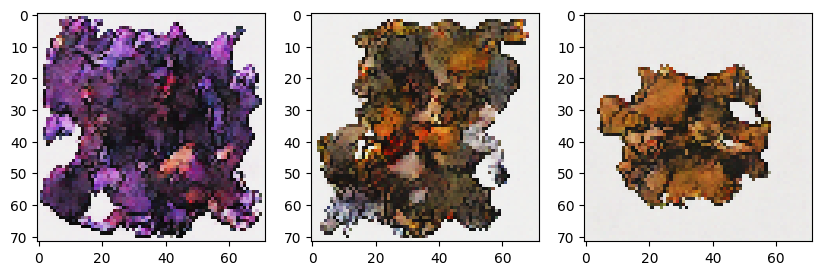

0.04058333:  15%|█▍        | 14999/100001 [13:09<1:10:41, 20.04it/s]

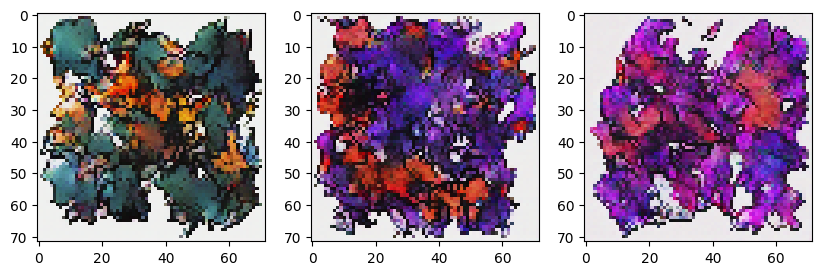

0.03517473:  16%|█▌        | 15999/100001 [14:01<1:09:49, 20.05it/s]

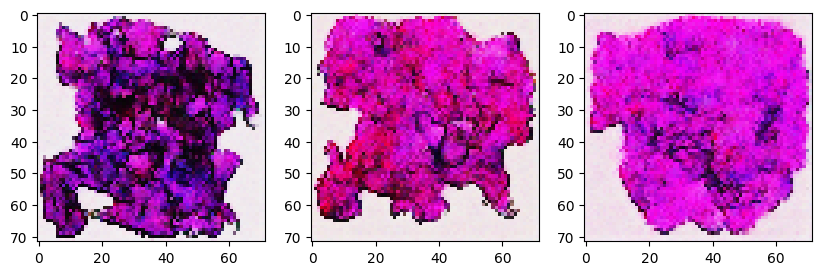

0.02773020:  17%|█▋        | 17000/100001 [14:54<1:09:05, 20.02it/s]

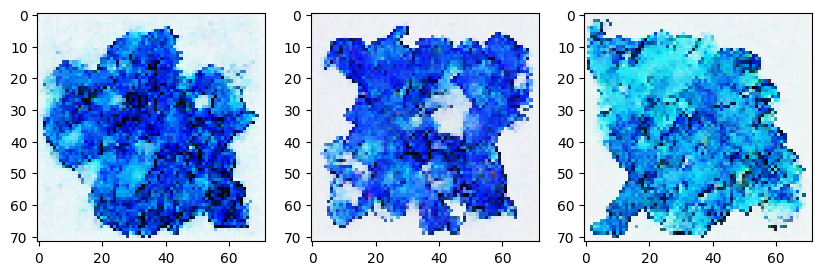

0.02105837:  18%|█▊        | 18000/100001 [15:47<1:08:11, 20.04it/s]

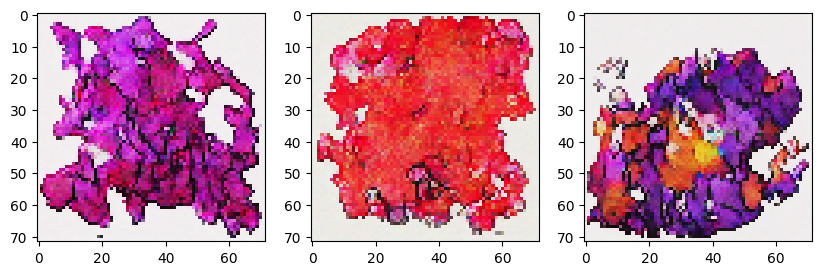

0.02446540:  19%|█▉        | 18998/100001 [16:39<1:07:24, 20.03it/s]

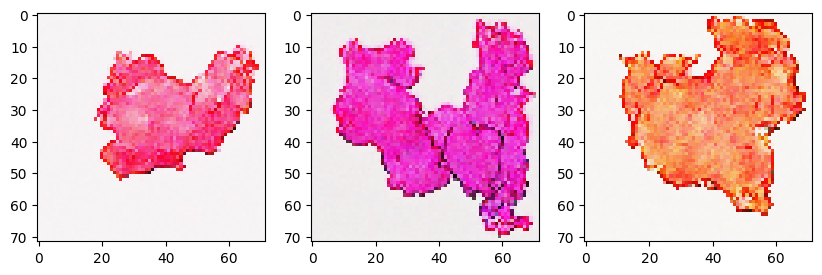

0.04713341:  20%|█▉        | 19998/100001 [17:32<1:06:37, 20.01it/s]

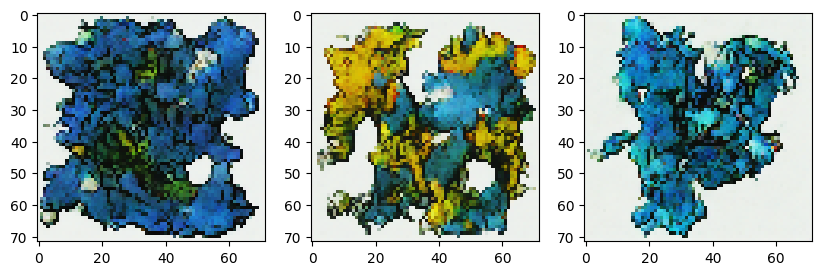

0.02319380:  21%|██        | 21000/100001 [18:24<1:05:42, 20.04it/s]

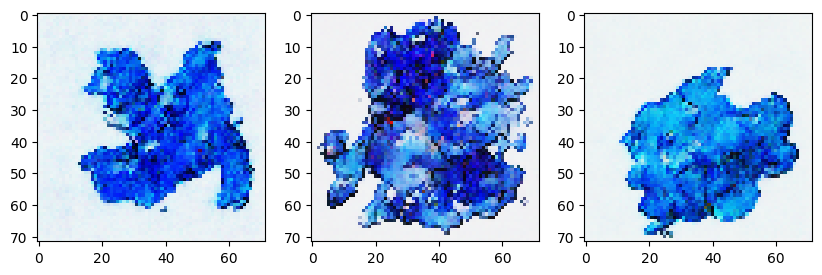

0.01753118:  22%|██▏       | 21998/100001 [19:17<1:04:57, 20.01it/s]

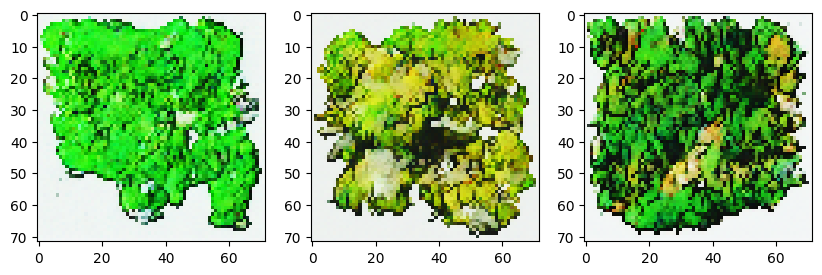

0.03190844:  23%|██▎       | 22999/100001 [20:10<1:04:00, 20.05it/s]

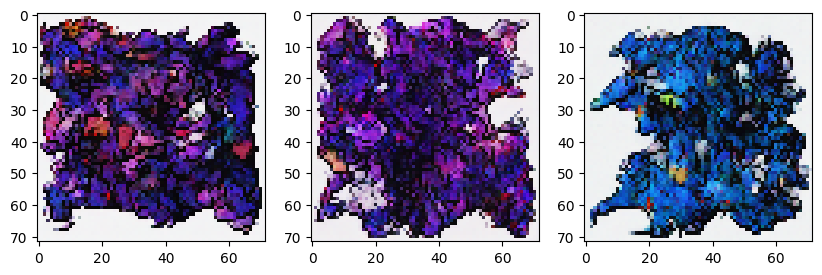

0.02126463:  24%|██▍       | 24000/100001 [21:02<1:03:13, 20.03it/s]

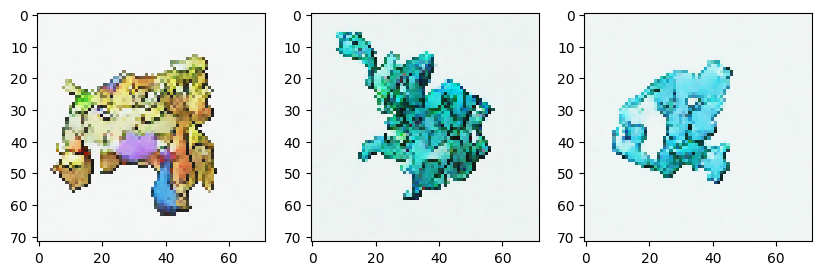

0.04813537:  25%|██▍       | 24998/100001 [21:55<1:02:26, 20.02it/s]

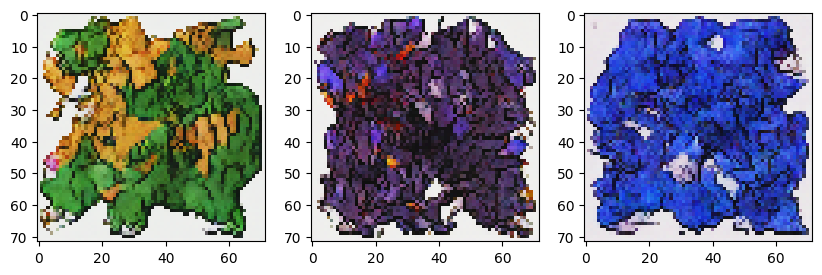

0.04759775:  26%|██▌       | 26000/100001 [22:48<1:01:41, 19.99it/s]

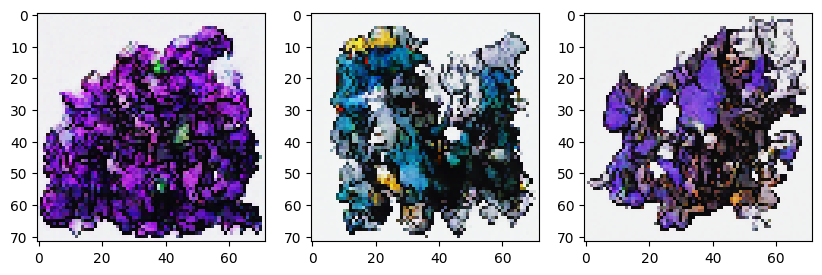

0.03553389:  27%|██▋       | 26998/100001 [23:40<1:00:46, 20.02it/s]

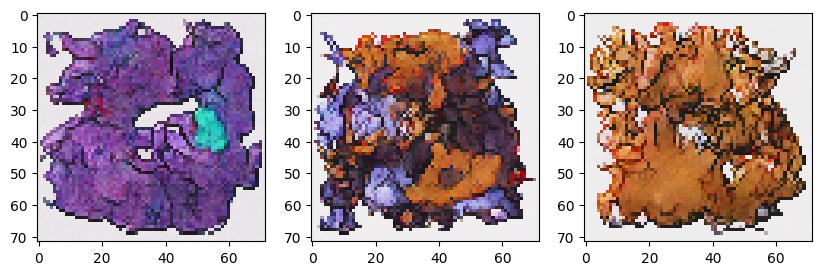

0.02149936:  28%|██▊       | 28000/100001 [24:33<59:56, 20.02it/s]  

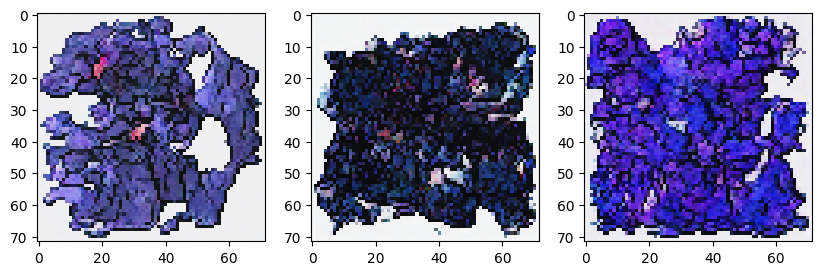

0.01522790:  29%|██▉       | 28999/100001 [25:25<59:04, 20.03it/s]  

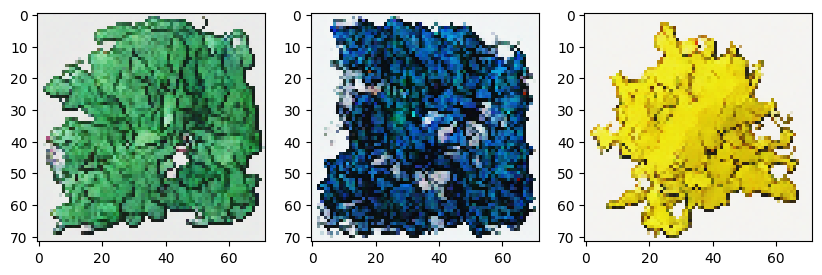

0.03168267:  30%|██▉       | 30000/100001 [26:18<58:19, 20.00it/s]  

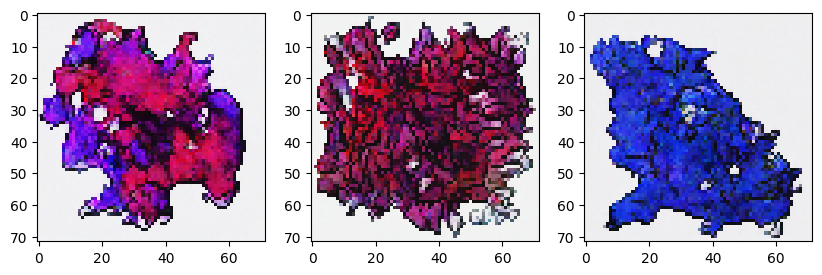

0.02939185:  31%|███       | 31000/100001 [27:11<57:25, 20.02it/s]  

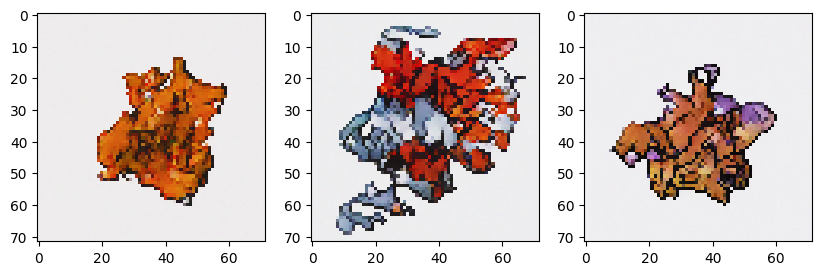

0.01987976:  32%|███▏      | 32000/100001 [28:03<56:34, 20.03it/s]  

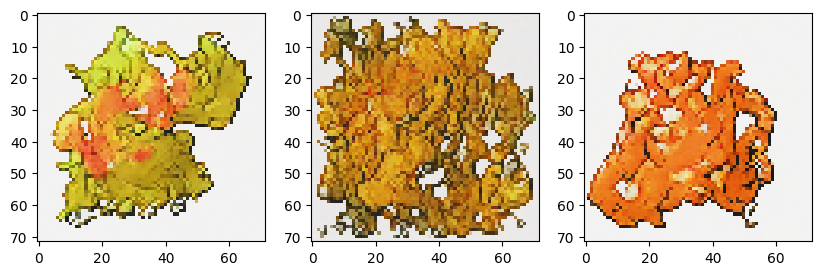

0.02179698:  33%|███▎      | 32998/100001 [28:56<55:45, 20.03it/s]  

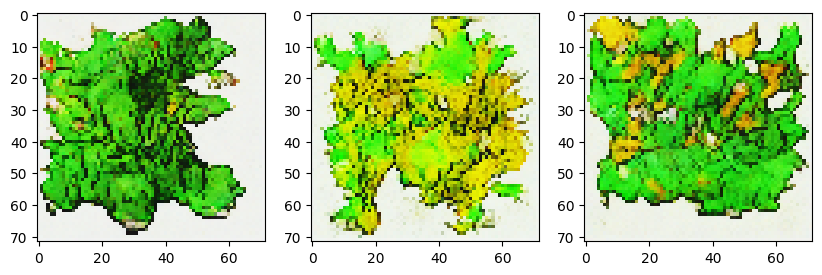

0.02924213:  34%|███▍      | 33998/100001 [29:49<54:53, 20.04it/s]  

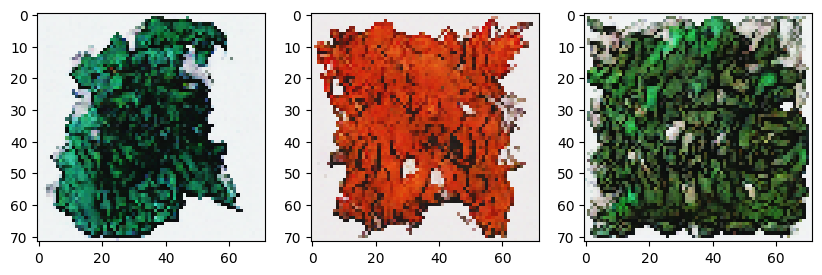

0.02724729:  35%|███▍      | 35000/100001 [30:41<54:05, 20.03it/s]  

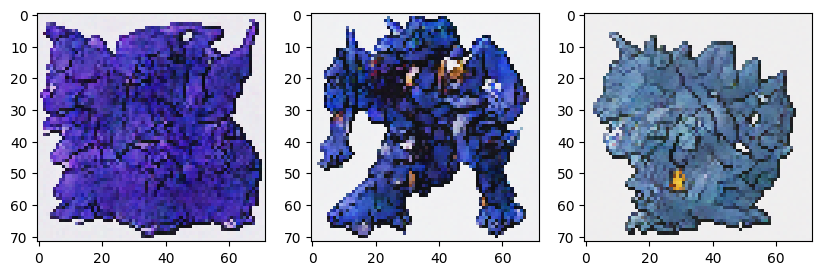

0.02721594:  36%|███▌      | 35999/100001 [31:34<53:12, 20.05it/s]  

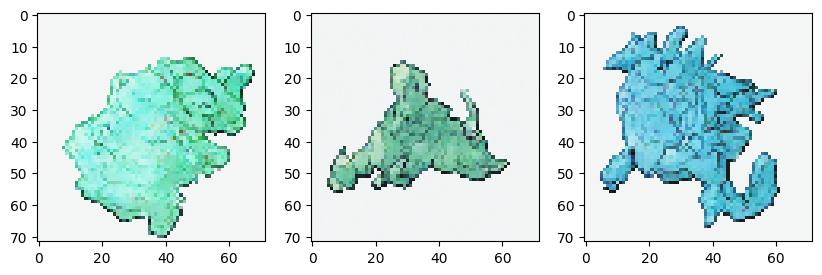

0.02305652:  37%|███▋      | 37000/100001 [32:27<52:24, 20.04it/s]  

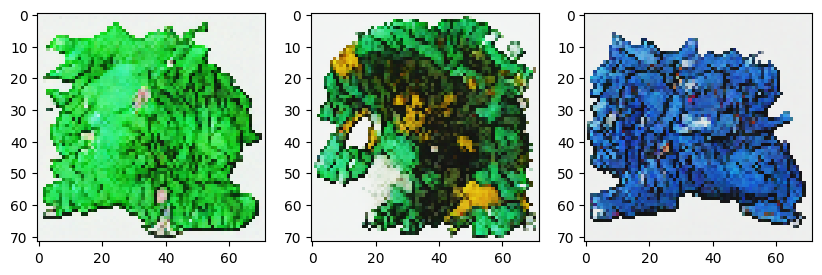

0.04275237:  38%|███▊      | 38000/100001 [33:19<51:35, 20.03it/s]  

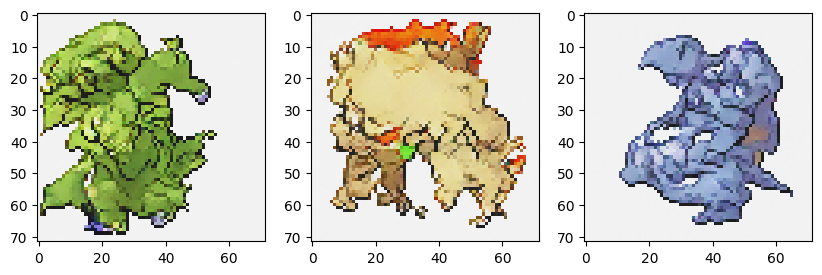

0.02254518:  39%|███▉      | 39000/100001 [34:12<50:44, 20.04it/s]  

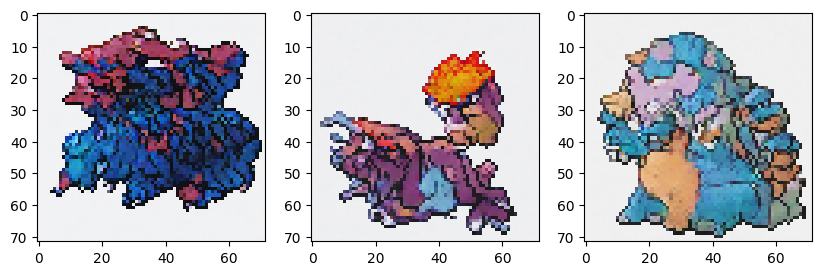

0.03127236:  40%|███▉      | 39998/100001 [35:04<49:56, 20.02it/s]  

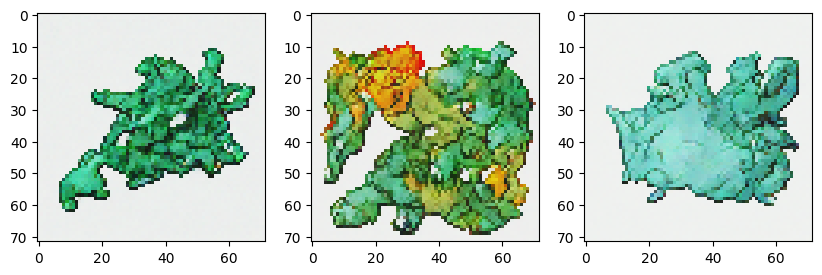

0.03058036:  41%|████      | 41000/100001 [35:57<49:05, 20.03it/s]  

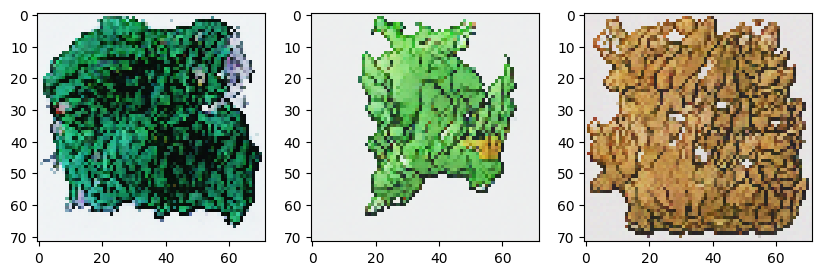

0.02188753:  42%|████▏     | 41999/100001 [36:50<48:16, 20.02it/s]  

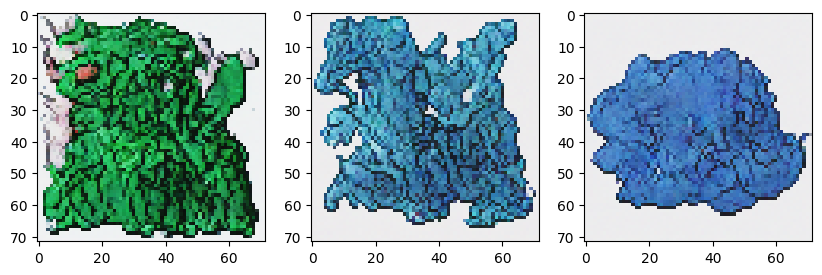

0.02213287:  43%|████▎     | 42998/100001 [37:42<47:27, 20.02it/s]  

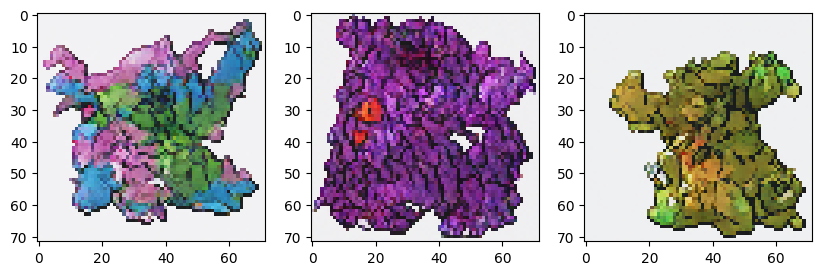

0.00676032:  44%|████▍     | 43999/100001 [38:35<46:31, 20.06it/s]  

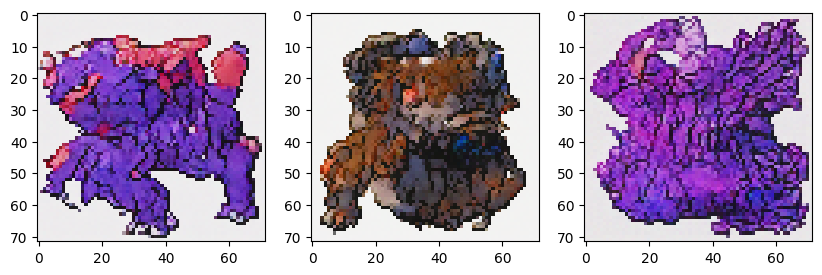

0.02005867:  45%|████▍     | 44999/100001 [39:27<45:45, 20.04it/s]  

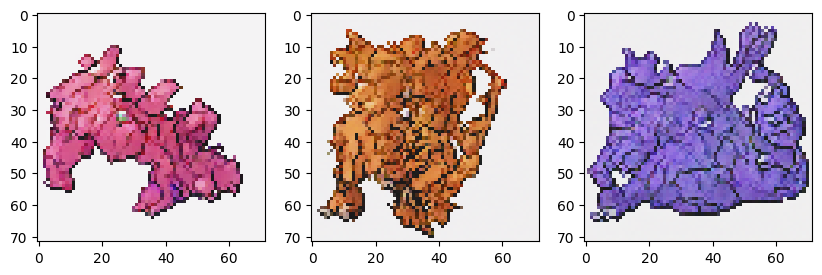

0.02673000:  46%|████▌     | 46000/100001 [40:20<44:53, 20.05it/s]  

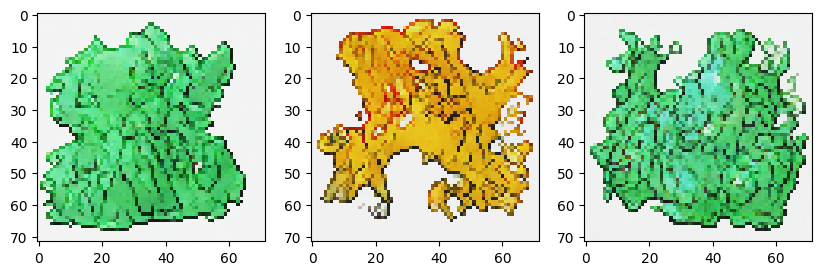

0.02934896:  47%|████▋     | 47000/100001 [41:13<44:05, 20.04it/s]  

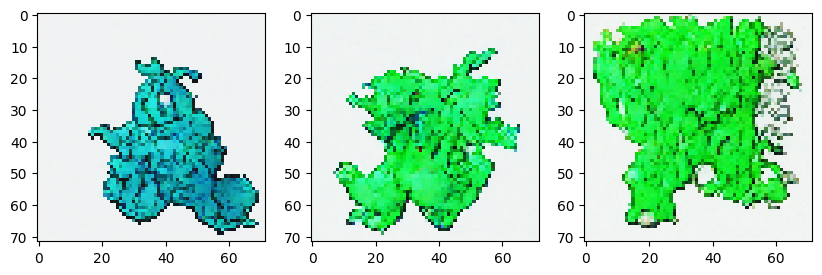

0.01099089:  48%|████▊     | 48000/100001 [42:05<43:17, 20.02it/s]  

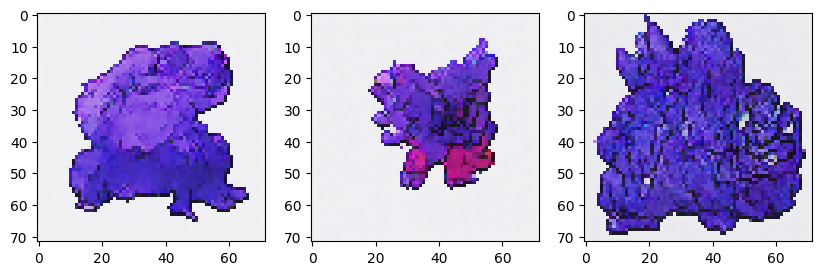

0.02524353:  49%|████▉     | 48999/100001 [42:58<42:27, 20.02it/s]  

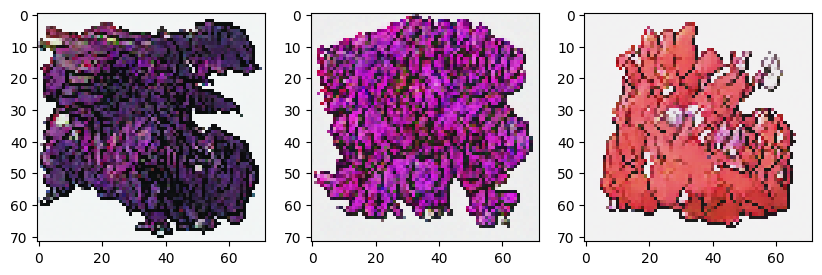

0.01405912:  50%|████▉     | 49998/100001 [43:51<41:32, 20.06it/s]  

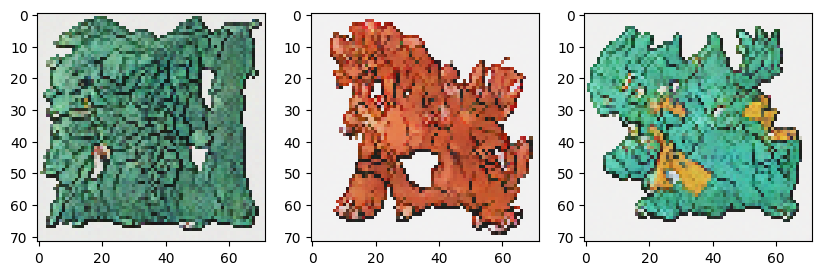

0.01763977:  51%|█████     | 51000/100001 [44:44<40:45, 20.04it/s]  

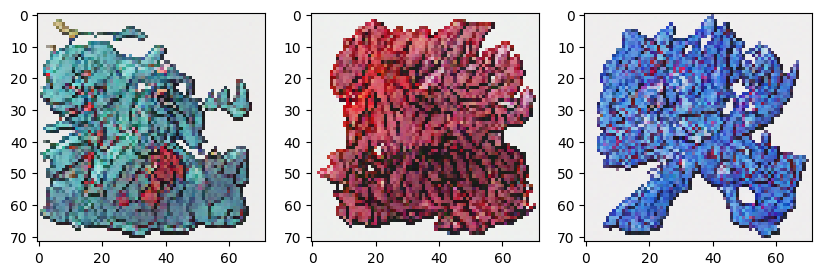

0.02257046:  52%|█████▏    | 52000/100001 [45:36<39:56, 20.03it/s]  

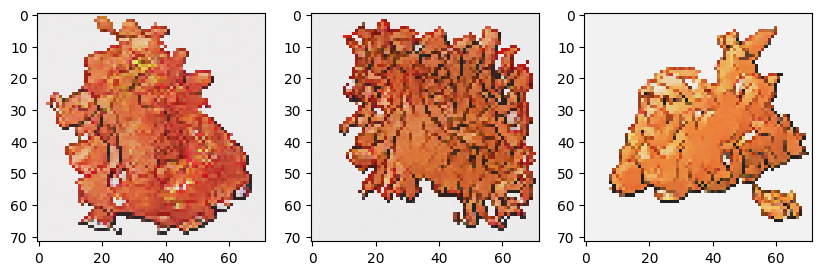

0.01455573:  53%|█████▎    | 52998/100001 [46:29<39:05, 20.04it/s]  

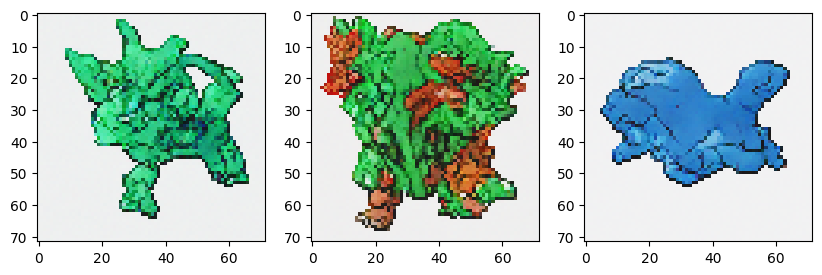

0.03743703:  54%|█████▍    | 54000/100001 [47:22<38:13, 20.05it/s]  

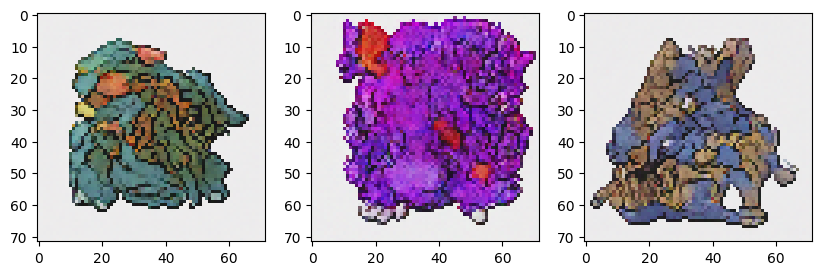

0.01707680:  55%|█████▍    | 55000/100001 [48:14<37:27, 20.03it/s]  

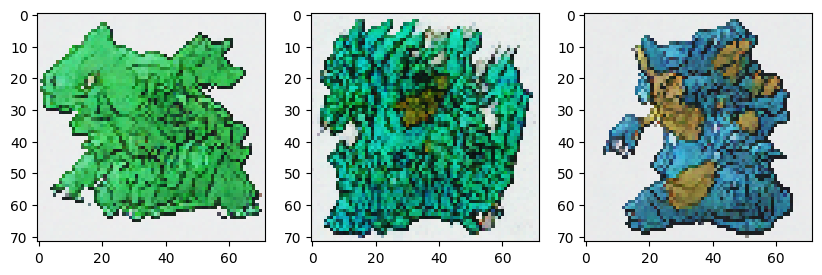

0.01885245:  56%|█████▌    | 56000/100001 [49:07<36:36, 20.03it/s]  

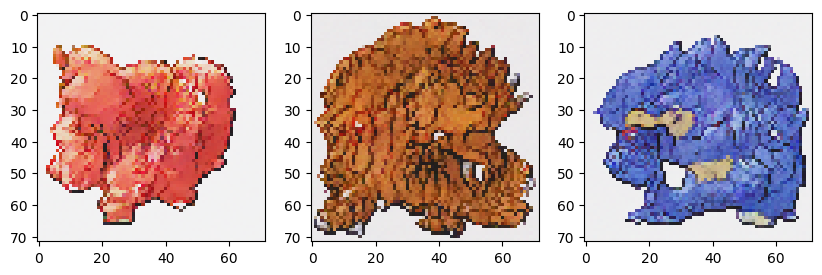

0.01560076:  57%|█████▋    | 57000/100001 [50:00<35:48, 20.02it/s]  

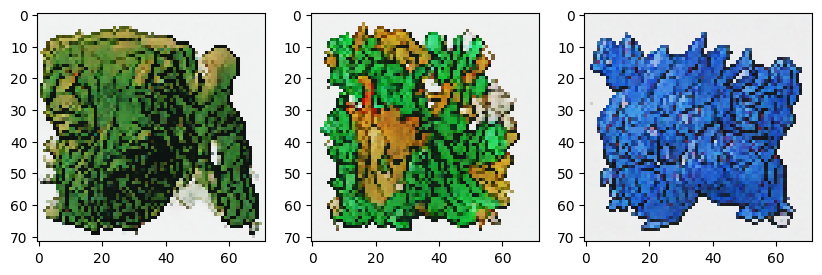

0.01842864:  58%|█████▊    | 57999/100001 [50:52<34:55, 20.04it/s]  

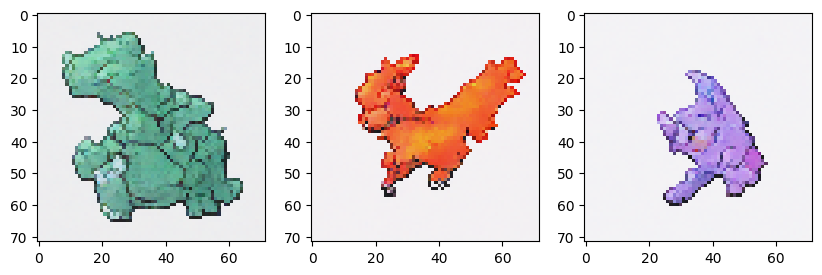

0.01007079:  59%|█████▉    | 58999/100001 [51:45<34:08, 20.02it/s]  

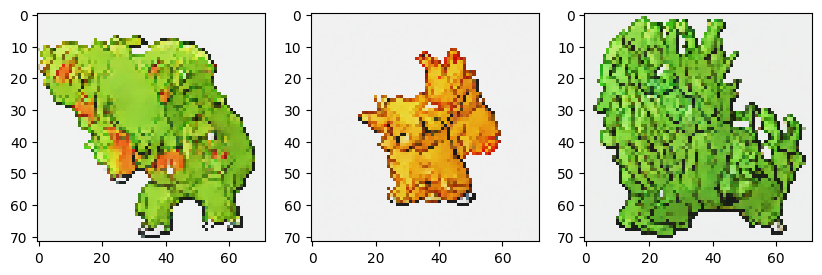

0.01588898:  60%|█████▉    | 60000/100001 [52:37<33:16, 20.03it/s]  

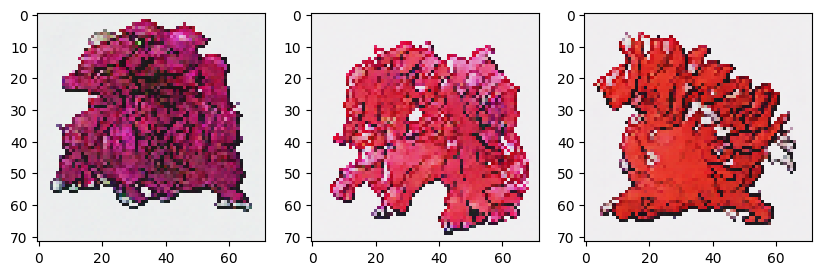

0.01534733:  61%|██████    | 60998/100001 [53:30<32:27, 20.02it/s]  

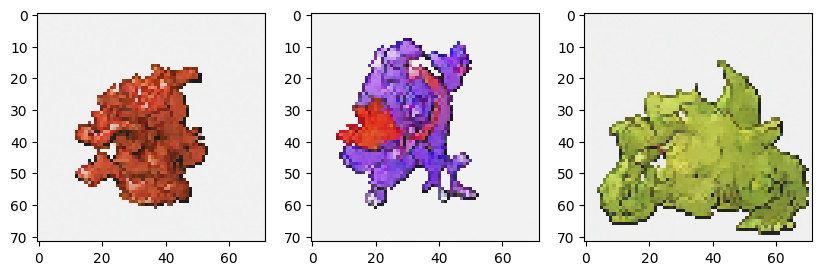

0.02645604:  62%|██████▏   | 61999/100001 [54:23<31:37, 20.02it/s]  

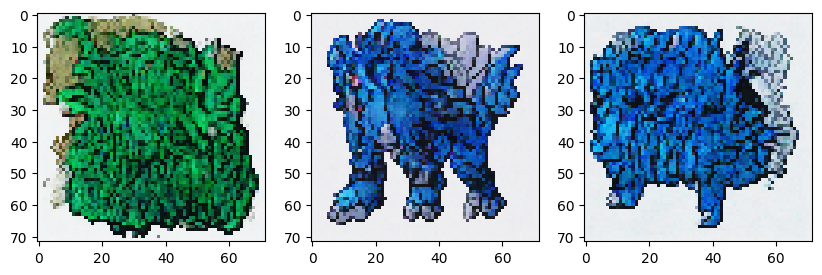

0.01648886:  63%|██████▎   | 62998/100001 [55:15<30:36, 20.15it/s]  

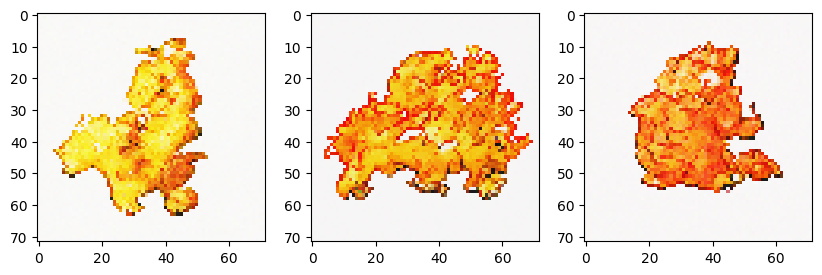

0.02194639:  64%|██████▍   | 64000/100001 [56:08<29:55, 20.05it/s]  

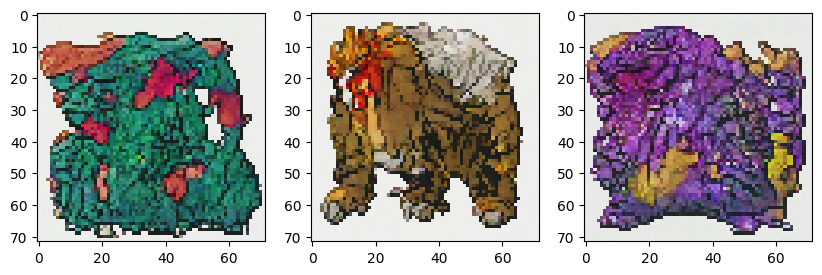

0.01413546:  65%|██████▍   | 64998/100001 [57:00<29:08, 20.02it/s]  

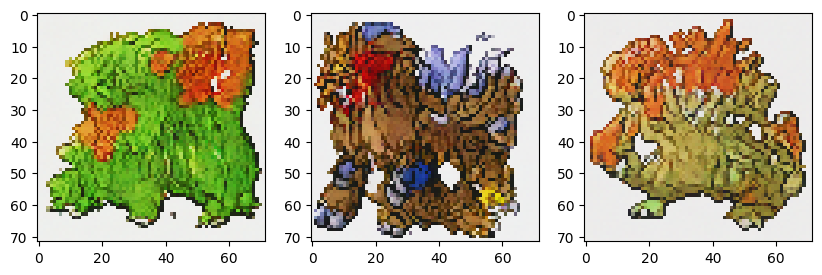

0.02166760:  66%|██████▌   | 66000/100001 [57:53<28:16, 20.04it/s]  

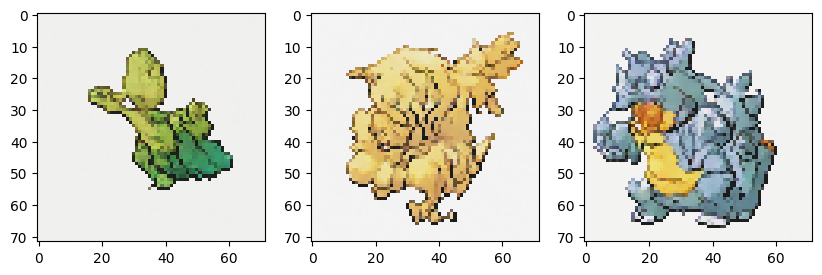

0.02070017:  67%|██████▋   | 66998/100001 [58:46<27:27, 20.04it/s]  

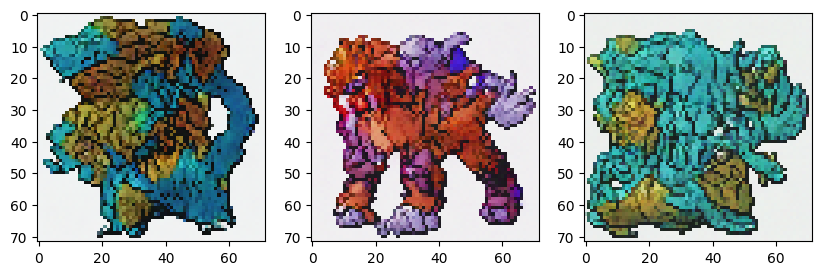

0.01711556:  68%|██████▊   | 67998/100001 [59:38<26:38, 20.02it/s]  

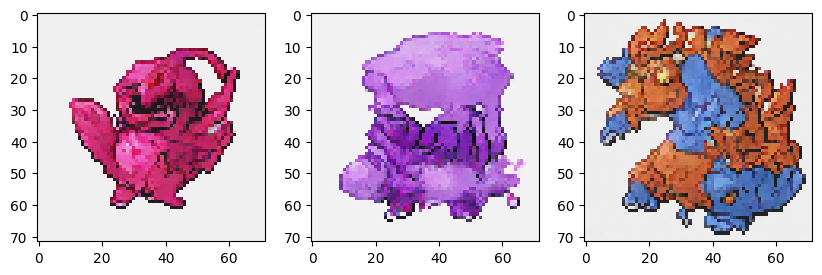

0.03419930:  69%|██████▉   | 68998/100001 [1:00:31<25:47, 20.03it/s]

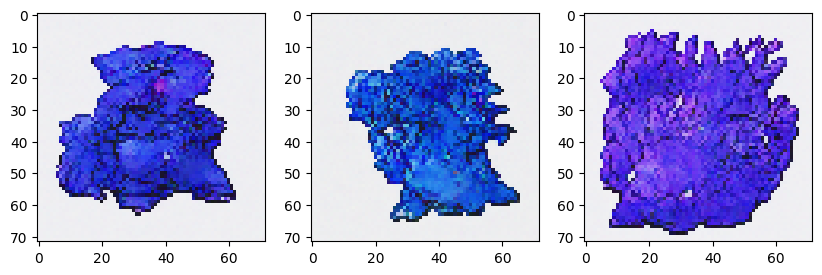

0.02059803:  70%|██████▉   | 69999/100001 [1:01:24<25:00, 20.00it/s]  

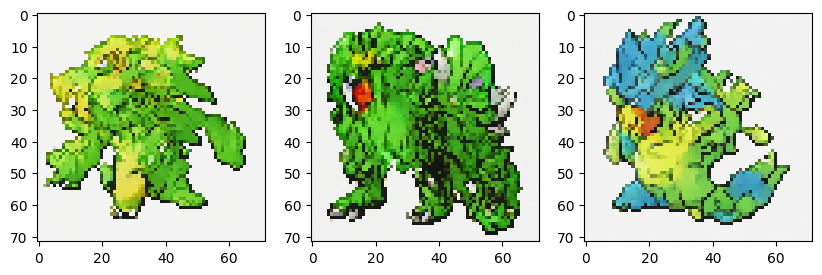

0.02090263:  71%|███████   | 70998/100001 [1:02:16<24:05, 20.06it/s]  

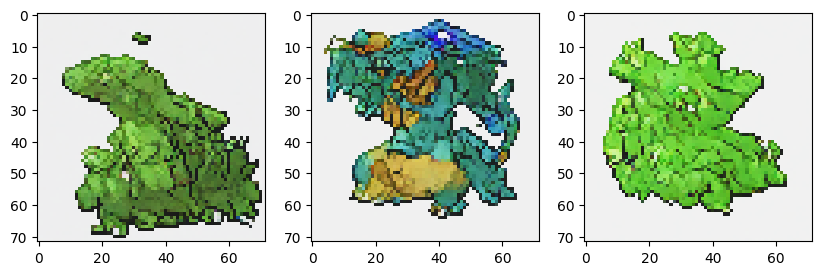

0.02713932:  72%|███████▏  | 71998/100001 [1:03:09<23:20, 20.00it/s]  

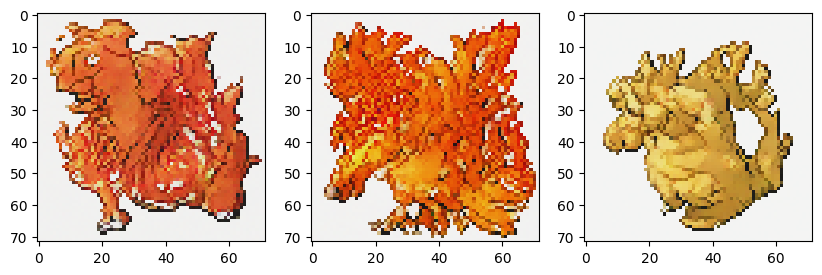

0.02918331:  73%|███████▎  | 72999/100001 [1:04:01<22:26, 20.06it/s]  

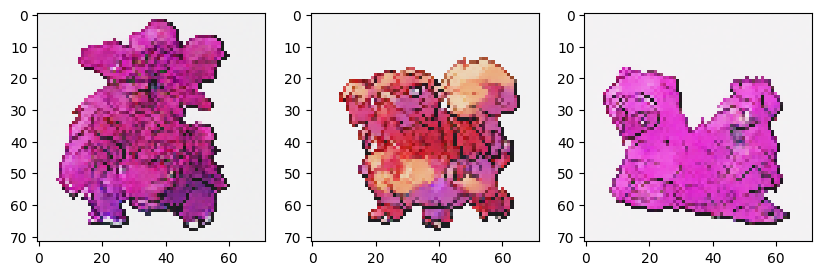

0.01662052:  74%|███████▍  | 74000/100001 [1:04:54<21:37, 20.03it/s]  

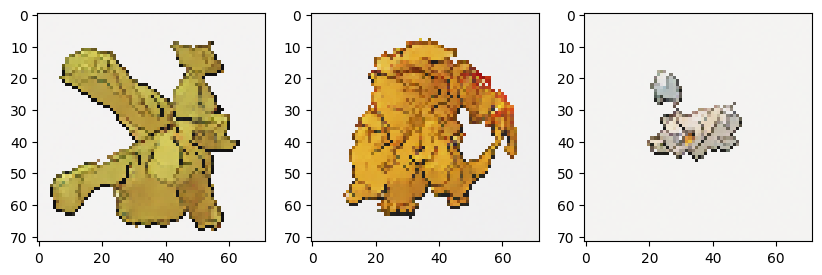

0.01771906:  75%|███████▍  | 75000/100001 [1:05:47<20:48, 20.03it/s]  

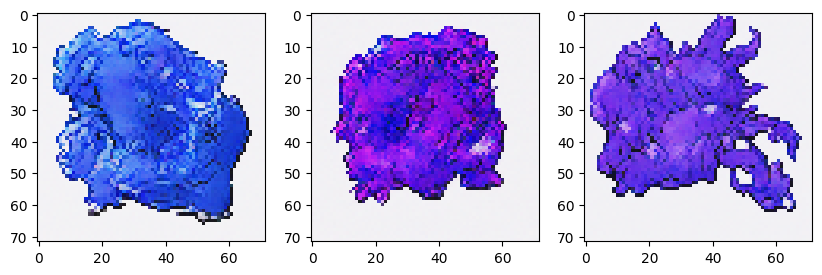

0.01462634:  76%|███████▌  | 76000/100001 [1:06:40<19:59, 20.01it/s]  

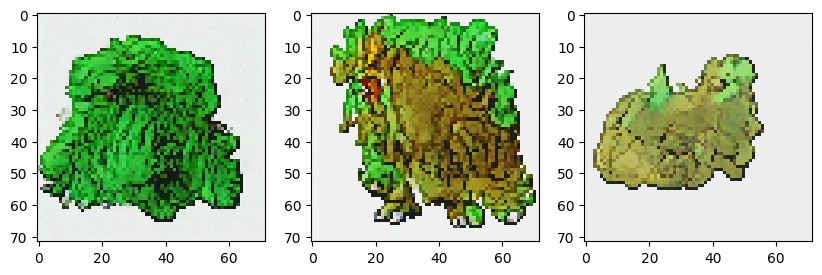

0.02148253:  77%|███████▋  | 76998/100001 [1:07:32<19:20, 19.82it/s]  

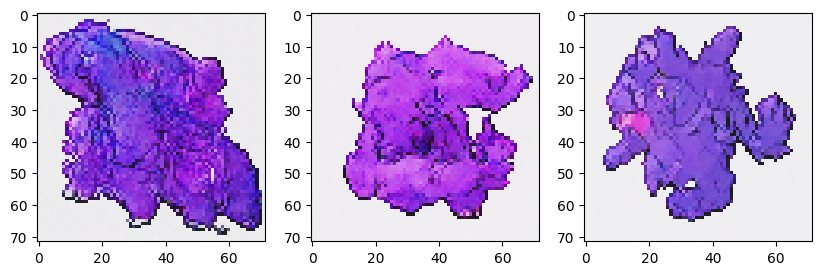

0.01618200:  78%|███████▊  | 78000/100001 [1:08:25<18:16, 20.06it/s]  

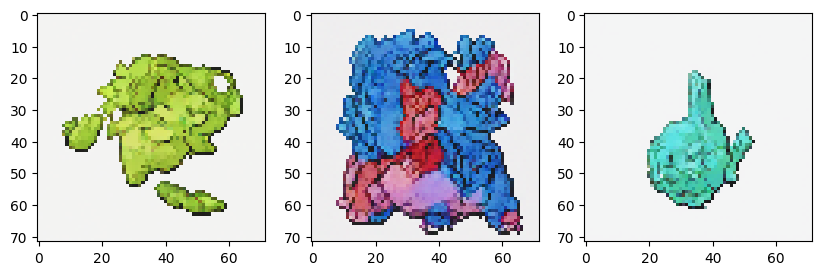

0.01434135:  79%|███████▉  | 78999/100001 [1:09:18<17:28, 20.04it/s]  

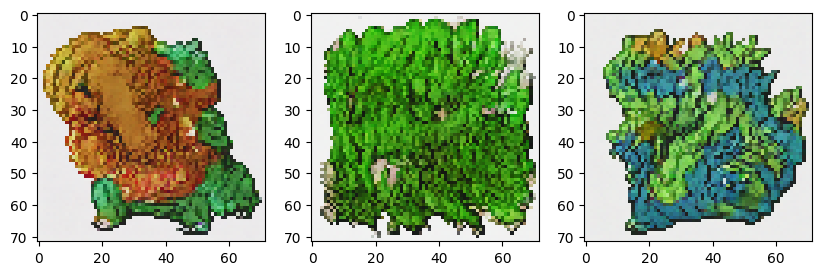

0.01421806:  80%|███████▉  | 80000/100001 [1:10:10<16:40, 20.00it/s]  

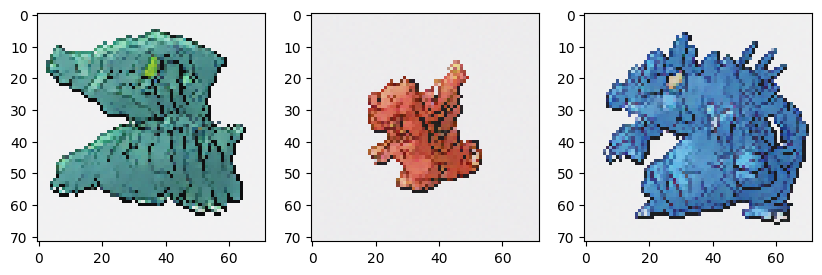

0.03231805:  81%|████████  | 80999/100001 [1:11:03<15:48, 20.02it/s]  

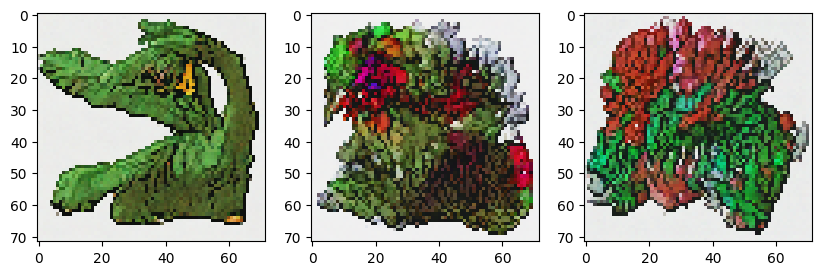

0.01269217:  82%|████████▏ | 82000/100001 [1:11:56<14:59, 20.02it/s]  

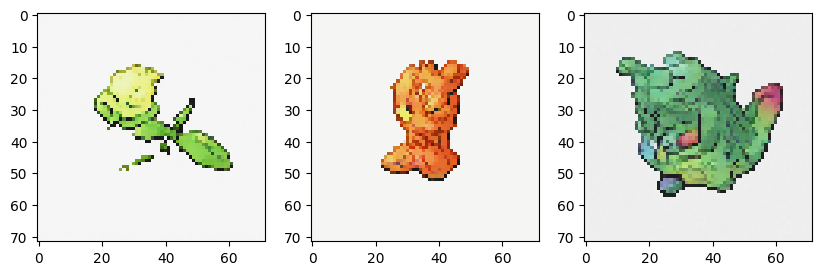

0.01655884:  83%|████████▎ | 83000/100001 [1:12:48<14:08, 20.05it/s]  

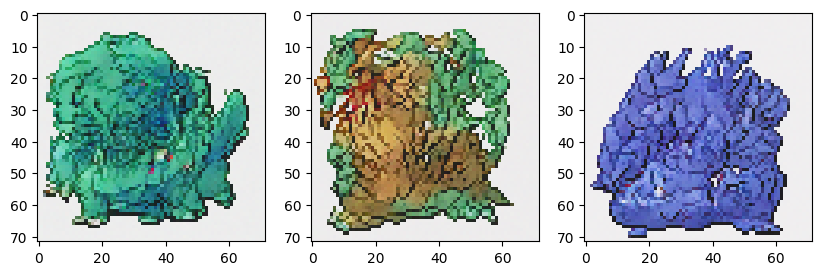

0.01355450:  84%|████████▍ | 84000/100001 [1:13:41<13:19, 20.02it/s]  

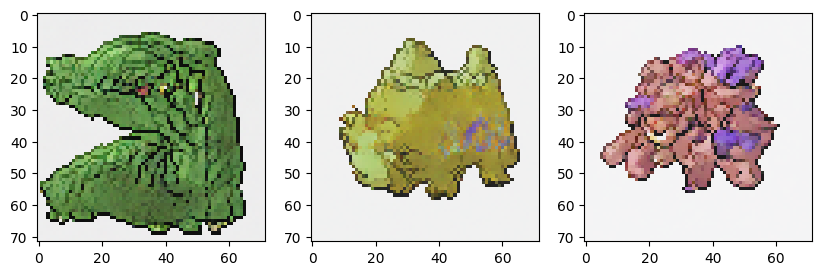

0.01453223:  85%|████████▍ | 84998/100001 [1:14:33<12:28, 20.05it/s]  

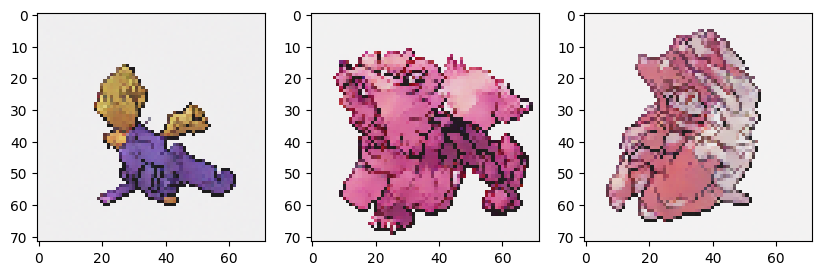

0.02412012:  86%|████████▌ | 85999/100001 [1:15:26<11:39, 20.02it/s]  

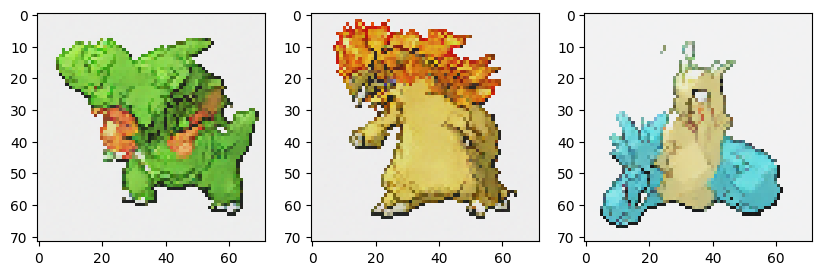

0.01270799:  87%|████████▋ | 86998/100001 [1:16:19<10:48, 20.06it/s]  

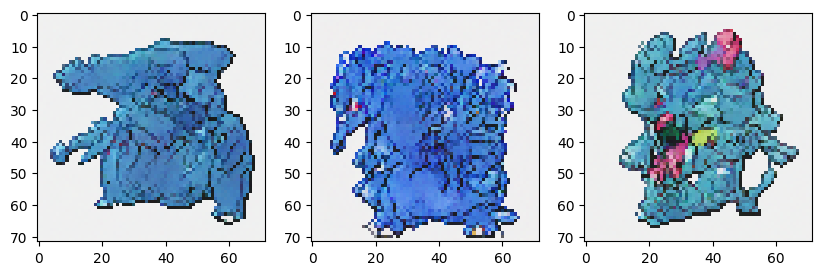

0.02300719:  88%|████████▊ | 87998/100001 [1:17:11<10:00, 19.97it/s]  

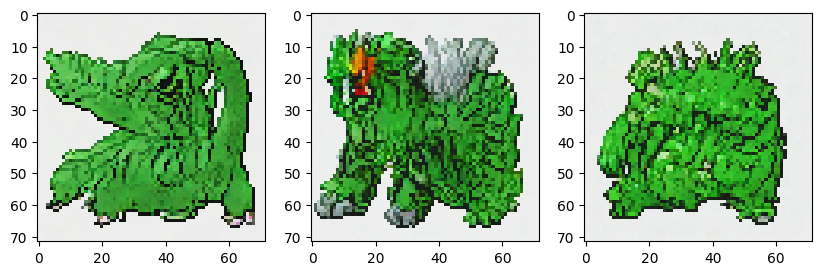

0.02567919:  89%|████████▉ | 88999/100001 [1:18:04<09:08, 20.05it/s]  

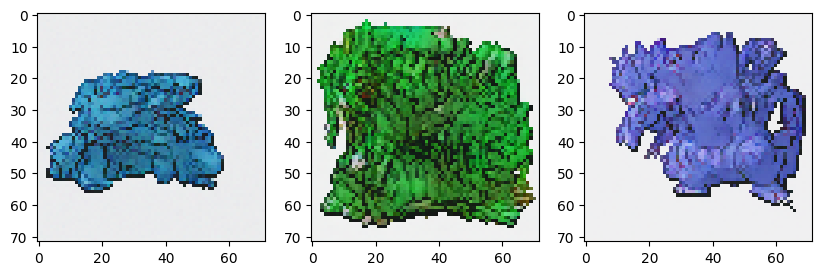

0.02435471:  90%|████████▉ | 89999/100001 [1:18:57<08:19, 20.01it/s]

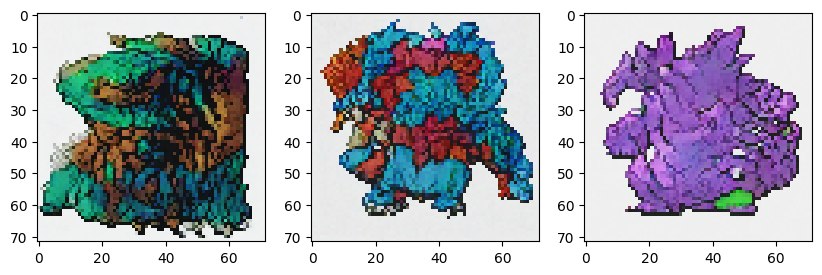

0.02770085:  91%|█████████ | 90998/100001 [1:19:49<07:28, 20.06it/s]

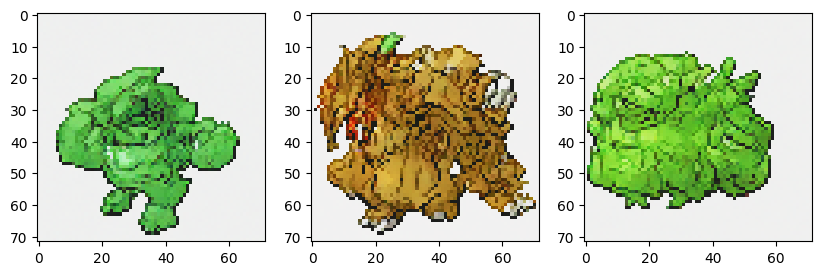

0.01248696:  92%|█████████▏| 92000/100001 [1:20:42<06:39, 20.04it/s]

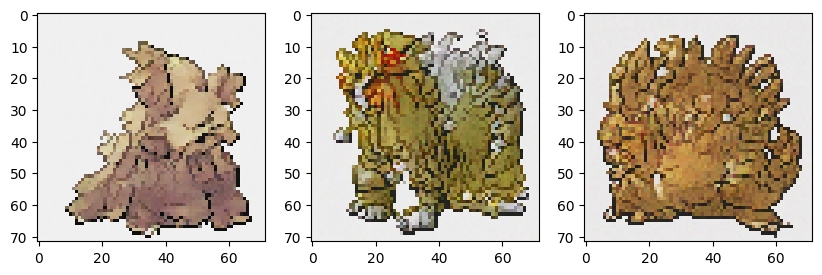

0.01537637:  93%|█████████▎| 92999/100001 [1:21:35<05:49, 20.03it/s]

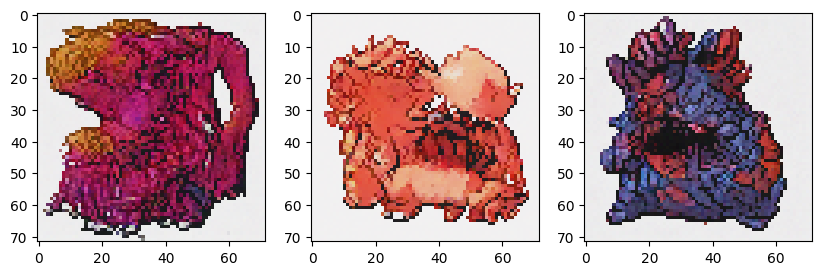

0.01265598:  94%|█████████▍| 94000/100001 [1:22:27<04:59, 20.04it/s]

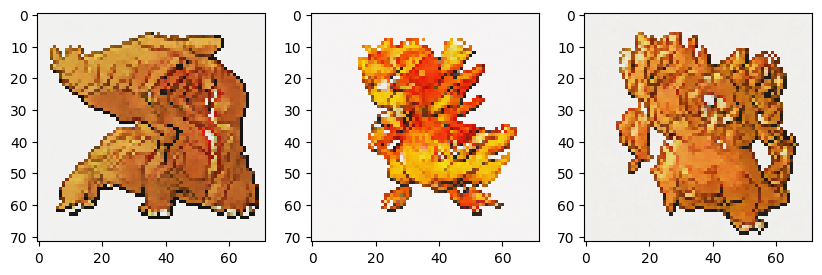

0.02143193:  95%|█████████▍| 94999/100001 [1:23:20<04:09, 20.02it/s]

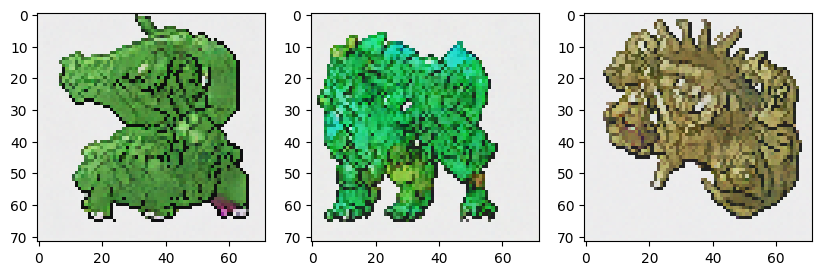

0.01671056:  96%|█████████▌| 95999/100001 [1:24:12<03:20, 20.00it/s]

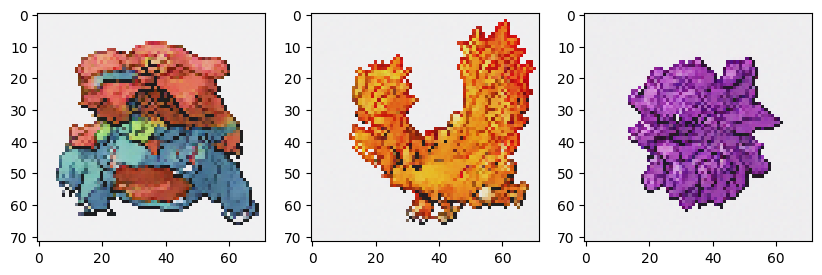

0.02400645:  97%|█████████▋| 97000/100001 [1:25:05<02:29, 20.05it/s]

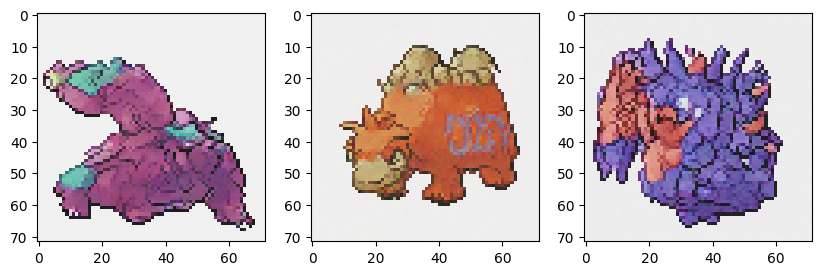

0.01952844:  98%|█████████▊| 97998/100001 [1:25:58<01:39, 20.06it/s]

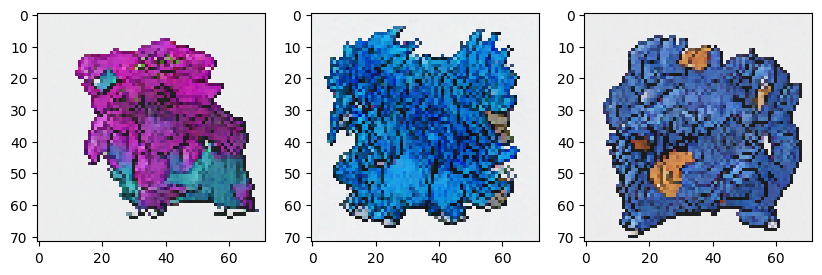

0.02033378:  99%|█████████▉| 98998/100001 [1:26:50<00:50, 20.05it/s]

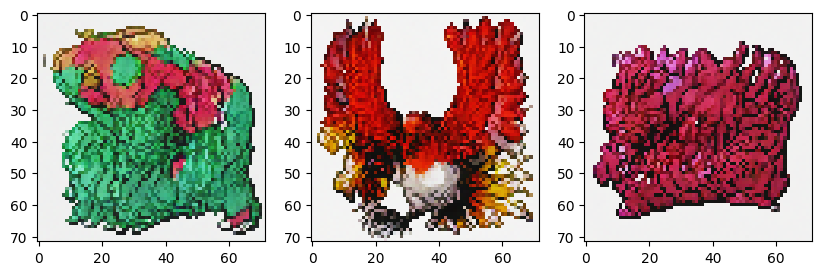

0.01866674: 100%|█████████▉| 99999/100001 [1:27:43<00:00, 20.04it/s]

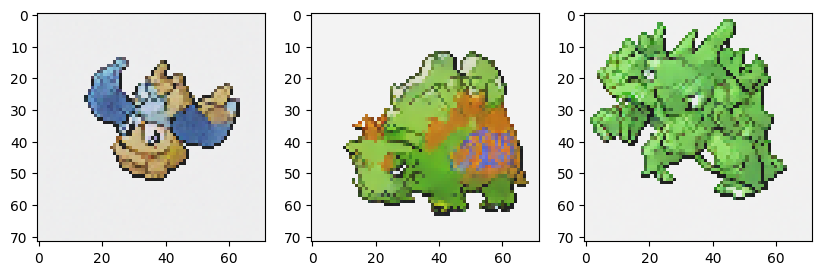

0.01566342: 100%|██████████| 100001/100001 [1:27:46<00:00, 18.99it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')